<a href="https://colab.research.google.com/github/InGev007/startup_acd/blob/main/lesson%2046/Lesson_46.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Лекція 46. Побудова прогнозів

##Завдання:
###Використовуючи датасет з файлу cardox.csv (об’єми продажів мережі супермаркетів) виконайте наступну роботу:

####-Проведіть попередній аналіз даних

####-Скорегуйте виявлені аномалії

####-Проведіть необхідні попередні підготовки даних (декомпозиція, коригування ряду, заповнення пропущених значень і. т. і.)

####-Оберіть модель і проведіть оцінку її метрик

####-Проведіть кінцеву діагностику для отриманої моделі

####-Виконайте прогноз на 30 років

####-Збережіть результати прогнозування у файл


## Загрузка необходимых библиотек и функций

In [1]:
!pip install adtk pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [3]:
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="best")
    plt.show()

In [4]:
#Функция получения метрик

def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

##Проведіть попередній аналіз даних

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cardox.csv', parse_dates=True, index_col="date")
df.head()

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 1958-03-01 to 2018-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   729 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


[<Axes: >]

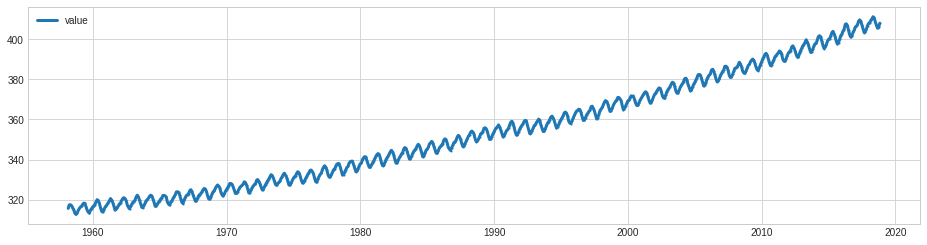

In [7]:
plot(df, ts_linewidth=3)

##Скорегуйте виявлені аномалії

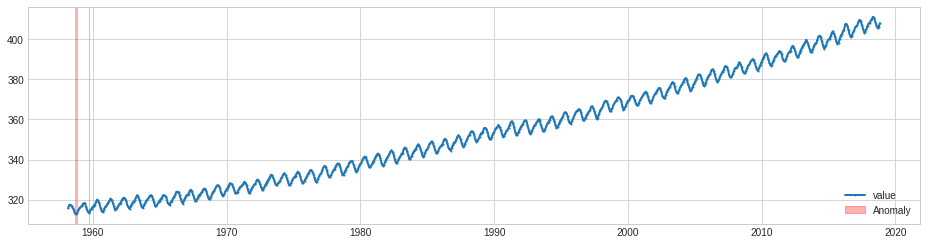

In [8]:
# Поиск аномалей
outlier_detector = OutlierDetector(LocalOutlierFactor())
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

In [9]:
anomalies[anomalies]

date
1958-09-01    True
1958-10-01    True
1958-11-01    True
1959-10-01    True
dtype: bool

In [10]:
# Замена аномалий данными прошлого месяца
df.loc['1958-09-01']=df.loc['1958-08-01']
df.loc['1958-10-01']=df.loc['1958-09-01']
df.loc['1958-11-01']=df.loc['1958-10-01']
df.loc['1959-10-01']=df.loc['1959-09-01']

##Проведіть необхідні попередні підготовки даних (декомпозиція, коригування ряду, заповнення пропущених значень і. т. і.)

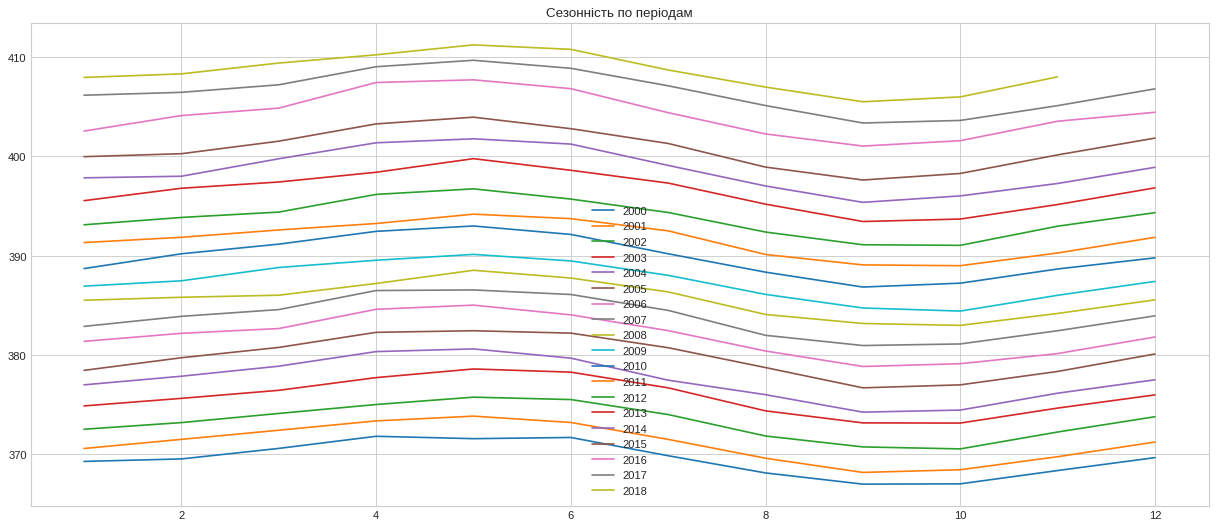

In [11]:
sesonal(df['2000':'2018'],12)

Text(0.5, 0.98, 'Мультиплікатива модель')

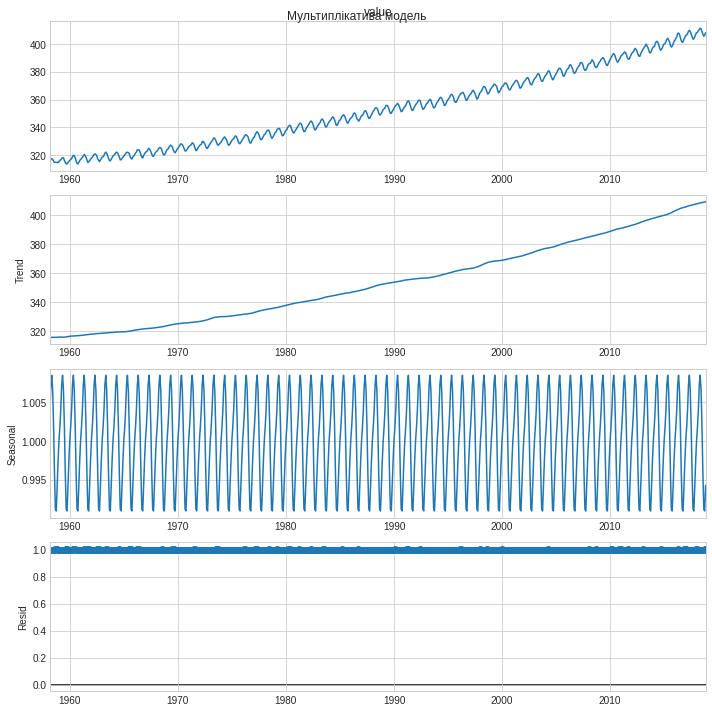

In [12]:
result_M = seasonal_decompose(df.value, model='multiplicative', extrapolate_trend=12)
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультиплікатива модель')

Text(0.5, 0.98, 'Адитивная модель')

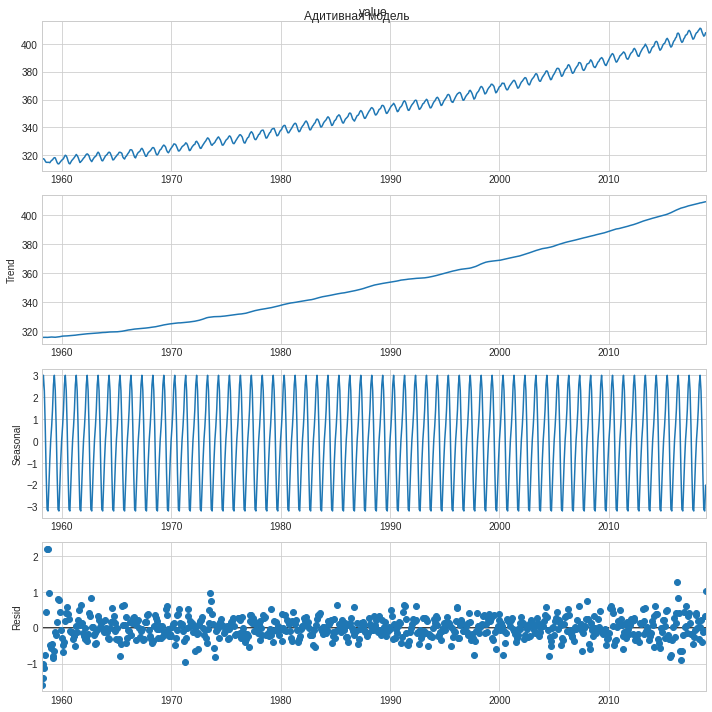

In [13]:
result_A = seasonal_decompose(df.value, model='additive', extrapolate_trend=12)
plt.rcParams.update({'figure.figsize': (10,10)})
result_A.plot().suptitle('Адитивная модель')

In [14]:
df['value'].isna().sum()

0

Нет пропущенных данных

## Оберіть модель і проведіть оцінку її метрик

###Модель Хольта Винтерса

In [15]:
fit1 = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='mul').fit()
forecastHV=fit1.forecast(12*30)

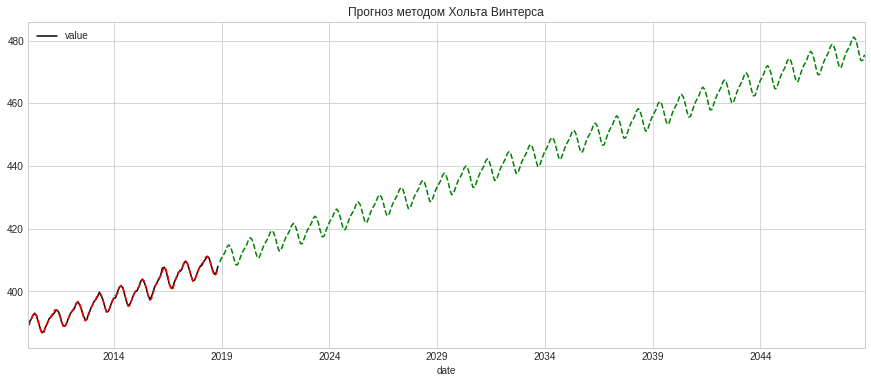

In [16]:
ax = df['2010':].plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса" )
fit1.fittedvalues['2010':].plot(ax=ax, style='--', color='red')
forecastHV.plot(ax=ax, style='--', color='green')
plt.show()

In [17]:
metrics(df, fit1.fittedvalues)

Тест на стаціонарність:
	T-статистика = -7.404
	P-значення = 0.000
Критичне значення :
	1%: -3.439593802573824 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.865619356068967 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.568942332870462 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 0.2464
MSE: 0.1043
MAPE: 0.0007
MPE: 0.0001
Стандартна похибка: 0.3229


###Модель Арима

In [24]:
#Знаходимо оптимальні параметри для моделі
model = auto_arima(df, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=541.647, Time=6.57 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2364.714, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1608.969, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2370.480, Time=0.08 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1107.392, Time=4.11 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=785.664, Time=3.02 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=551.260, Time=13.73 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=559.906, Time=13.79 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1436.157, Time=0.90 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=12.49 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=644.460, Time=12.99 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=17.98 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=508.161, Time=4.23 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept 

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [19]:
mod = sm.tsa.statespace.SARIMAX(df, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
results = mod.fit()

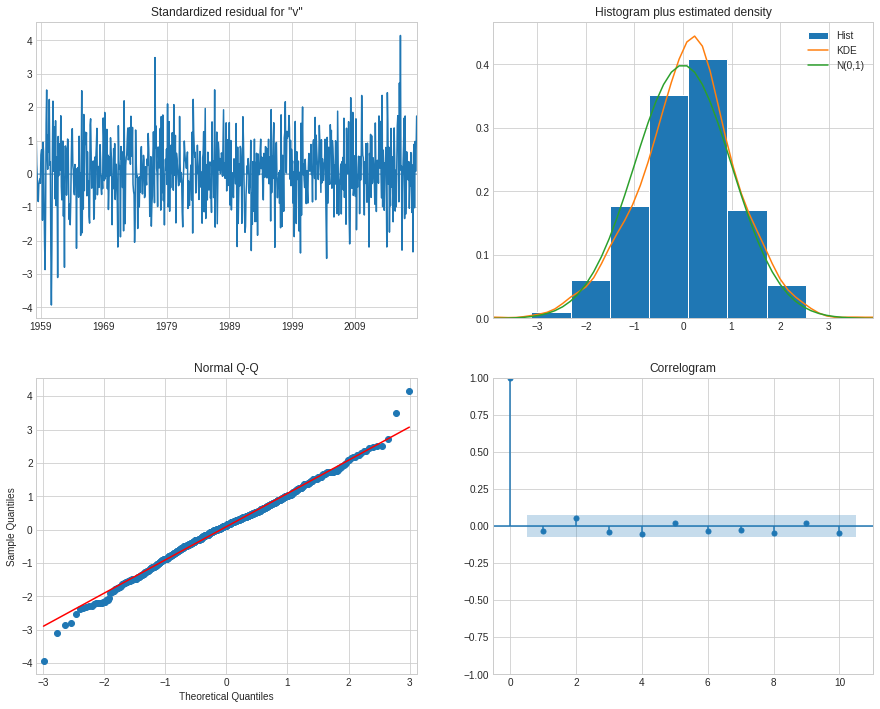

In [20]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

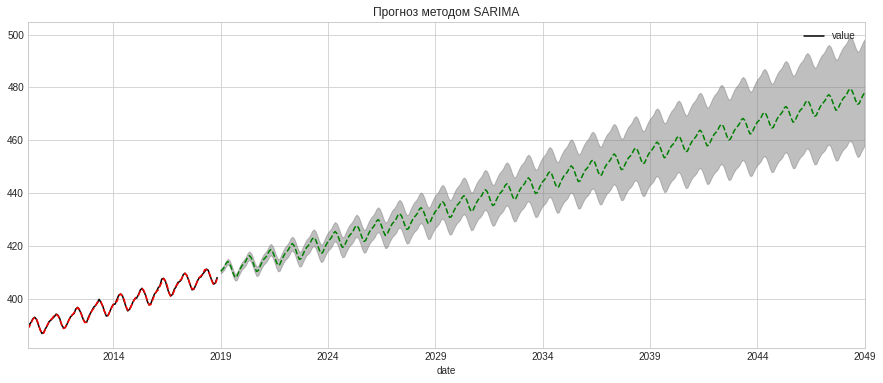

In [21]:
predict=results.get_prediction(start='2019', end='2049')
pred_ci = predict.conf_int()
ax = df['2010':].plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA" )
results.fittedvalues['2010':].plot(ax=ax, style='--', color='red')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='grey', alpha=.5)
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

In [22]:
metrics(df, results.fittedvalues)

Тест на стаціонарність:
	T-статистика = -7.710
	P-значення = 0.000
Критичне значення :
	1%: -3.439620010600208 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.8656309041017756 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.5689484851894413 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 0.6978
MSE: 136.8481
MAPE: 0.0021
MPE: 0.0015
Стандартна похибка: 11.6982


##Зберегти результати прогнозування у файл

In [23]:
predict_df = pd.DataFrame({'Predict': predict.predicted_mean,
                           'Low': pred_ci['lower value'],
                           'Up': pred_ci['upper value']})
predict_df.to_csv('predict_df.csv')